In [26]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn_extra.cluster import KMedoids
import plotly.graph_objects as go
from kneed import KneeLocator

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import math

from lightgbm import LGBMClassifier
from sklearn.metrics import silhouette_score
import shap

# set the maximum number of rows and columns to display to unlimited
#pd.set_option("display.max_rows", None, "display.max_columns", None) 

# Read in the data
data = pd.read_csv("C:/Users/Kiat Kai/Desktop/NOTES/FYP/Full Dataset/diamante_eligible_5June.csv")
data.drop(columns = ["Unnamed: 0"], inplace = True)

In [5]:
# FIll the data with missing data with imputating 5 days
data = data.fillna(data.rolling(5,min_periods=1).mean())

In [6]:
# Removed the outlier from today steps
data = data[data.today_steps < 50000]

# We want to keep time_msg but it has 828 missing values as the participants did not receive any message at all
# So to keep it, we replace the time_msg NA with T0
data["time_msg"] = data["time_msg"].replace(np.nan, "T0")

# VARIABLE: timemsg
data = data.drop(data[data.time_msg == "2+ Time Frames"].index, axis = 0)

# We now try to drop columns with missing values at all
data_dropnan = data.drop(["eth_other","income_ladder","nat_lang_able","country","years_us","start_phq8_prd",
                          "start_gad_prd","days.since.F0","days.since.F1","days.since.F2","days.since.F3","days.since.F4"
                          ,"days.since.M0","days.since.M1","days.since.M2","days.since.M3","days.since.T1","days.since.T2",
                          "days.since.T3","days.since.T4","days.since.ind","days.since.soc","weekly_goal","yesterday_progress",
                          "week_progress","daybefyest_steps","step_change_yest","step_change_today"], axis=1)

# Next, I also drop columns that may not be useful for our analysis
data_dropnan = data_dropnan.drop(["Fcorrection","Mcorrection","individual","Start_Date",
                                   "date_baseline_visit","prediction","nat_language"] ,axis=1)

# We try to remove all those health questionaire (multiple columns kind)
data_dropnan1 = data_dropnan.drop(["start_soc_active","start_soc_months","start_ipaq_1","start_ipaq_2","start_ipaq_3",
                                   "start_phq8_1","start_phq8_2","start_phq8_3","start_phq8_4","start_phq8_5","start_phq8_6",
                                   "start_phq8_7","start_phq8_8","start_gad_1","start_gad_2","start_gad_3",
                                   "start_gad_4","start_gad_5","start_gad_6","start_gad_7","start_bads_1r_1",
                                   "start_bads_2_1","start_bads_3_1","start_bads_4_1","start_bads_5_1","start_bads_6r_1",
                                   "start_bads_7r_1","start_bads_8r_1","start_bads_9_1","start_leids_1","start_leids_1",
                                   "start_leids_2","start_leids_3","start_leids_4","start_leids_5","start_leids_6",
                                    "loneliness_1","loneliness_2","loneliness_3","neighborhood_1","neighborhood_2",
                                   "neighborhood_3","neighborhood_4r","neighborhood_5","neighborhood_6","week_steps"]
                                   , axis = 1)

# Next, we remove some rows for some columns which has outliers
# VARIABLE: ETH
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="Asian or Pacific Islander,Hispanic/Latino(a)"].index, axis = 0)
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="Asian or Pacific Islander,White or Caucasian,Multi-ethnic"].index, axis = 0)
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="Asian or Pacific Islander,White or Caucasian"].index, axis = 0)
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="White or Caucasian,Hispanic/Latino(a),Multi-ethnic"].index, axis = 0)
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="White or Caucasian,Hispanic/Latino(a),Other"].index, axis = 0)
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="White or Caucasian,Other"].index, axis = 0)
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.eth =="Black or African American,Hispanic/Latino(a)"].index, axis = 0)

# VARIABLE: gender
data_dropnan1 = data_dropnan1.drop(data_dropnan1[data_dropnan1.gender == "Other or Not Listed; Please Specify:"].index, axis = 0)

# Remove rows with anymore nan's
data_dropnan1 = data_dropnan1.dropna()

# FINAL DATASET:
filled_dataset = data_dropnan1

# Exploratory Descriptive Analysis

### Distribution of today_steps

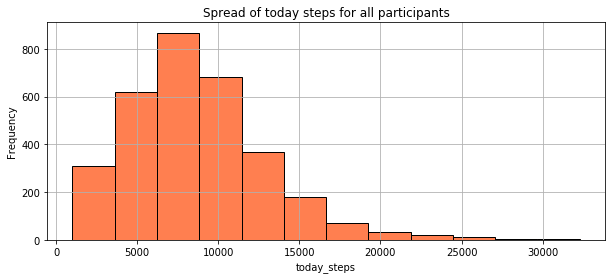

In [7]:
data_today_steps = filled_dataset.today_steps # We plot the distribution of all the today_steps 
plt.figure(figsize = (10,4))
plt.hist(data_today_steps, bins = 12, color = "coral", ec='black')
plt.title("Spread of today steps for all participants")
plt.xlabel("today_steps")
plt.ylabel("Frequency")
plt.grid(b='dark')
plt.savefig('today_steps.tif')

### Distribution of daily_goal

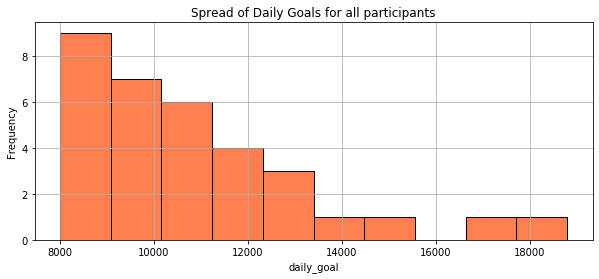

In [8]:
data_daily_goal = filled_dataset.daily_goal.unique() 
plt.figure(figsize = (10,4))
plt.hist(data_daily_goal, bins = 10, color = "coral", ec='black')
plt.title("Spread of Daily Goals for all participants")
plt.xlabel("daily_goal")
plt.ylabel("Frequency")
plt.grid(b="dark")
plt.savefig('daily_goal.tif')

### Correlation between numerical variables in the dataset

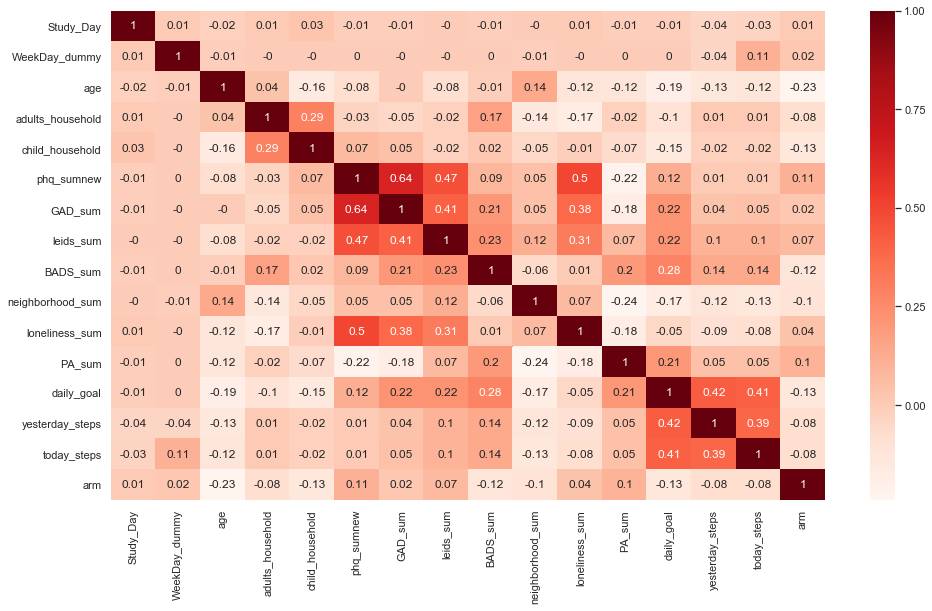

In [9]:
# Correlation between numerical variables in the data set
correlation_matrix = filled_dataset.corr().round(2)

sns.set(rc={'figure.figsize':(16,9)})
ax = sns.heatmap(data=correlation_matrix, annot=True, cmap = "Reds")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('correlation1.tif')

### Distribution of the number of days a participants' steps hit their daily goals throughout their 45 days duration

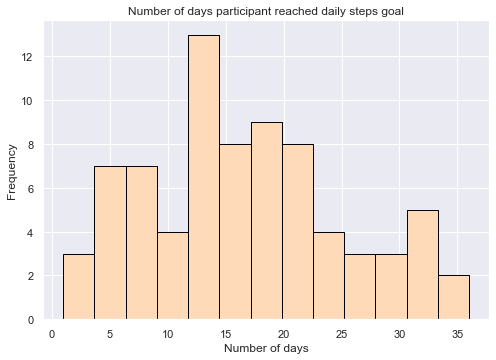

In [10]:
# Create a new column called target_hit, if a participant hit their daily step goals, 1 if hit, 0 if didn't hit
plt.figure(figsize = (8,5.5))
filled_dataset['target_hit'] = np.where(filled_dataset.today_steps >= filled_dataset.daily_goal, 1, 0)
filled_dataset.groupby(["ID_DIAMANTE"]).target_hit.sum().plot(kind="hist", ec = "black", color = "peachpuff", bins = 13)
plt.xlabel("Number of days")
plt.title("Number of days participant reached daily steps goal")
plt.savefig("target_hit.tif")

### Finding the average today_steps for each feedback messages and motivational messages

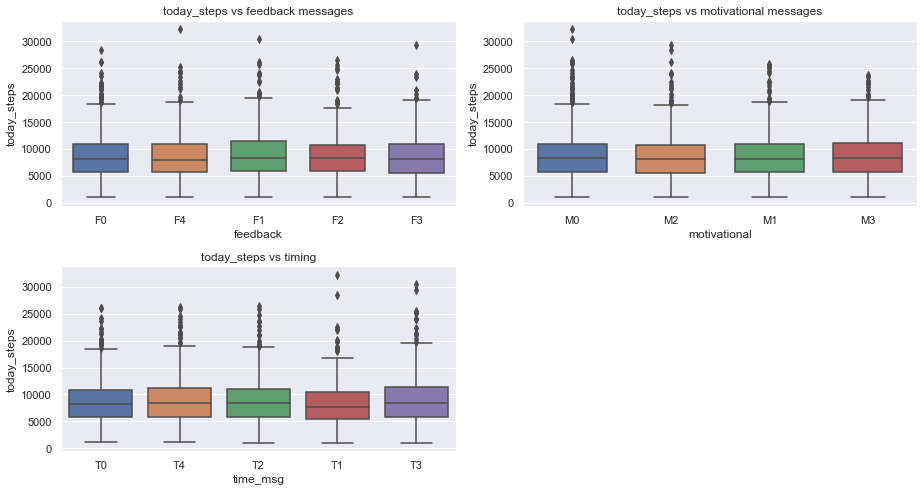

In [11]:
plt.figure(figsize = (13,7))

plt.subplot(2,2,1)
sns.boxplot(x = 'feedback', y = 'today_steps', data = filled_dataset, width = 0.7)
plt.title("today_steps vs feedback messages")

plt.subplot(2,2,2)
sns.boxplot(x = 'motivational', y = 'today_steps', data = filled_dataset, width = 0.7)
plt.title("today_steps vs motivational messages")

plt.subplot(2,2,3)
sns.boxplot(x="time_msg", y="today_steps", data=filled_dataset)  
plt.title("today_steps vs timing")

plt.tight_layout()
plt.savefig("mft.tif")

### Difference between the last day today_steps and the first day (baseline) today_steps for each participant

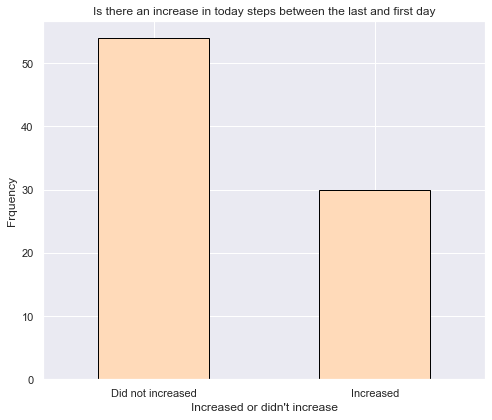

In [12]:
df1_participants = filled_dataset.ID_DIAMANTE.unique() # 84 participants with different id
diff = []
increase = np.zeros(84) # To store whether there are increase for each participants, 1 if yes, 0 if no
index = 0
for participant in df1_participants:
    # To get the difference between the last and first day of each participant
    difference = filled_dataset[filled_dataset["ID_DIAMANTE"] == participant].reset_index().today_steps[len(filled_dataset[filled_dataset["ID_DIAMANTE"] == participant])-1] - filled_dataset[filled_dataset["ID_DIAMANTE"] == participant].reset_index().today_steps[0]
    diff.append(difference)
    if difference > 0:
        increase[index] = 1
    index += 1

plt.figure(figsize=(7,6))
increase_or_decrease_dict = {0:"Did not increased", 1:"Increased"}
pd.Series(increase).value_counts().rename(increase_or_decrease_dict).plot(kind="bar", rot = 0, ec = "black", color = "peachpuff")
plt.xlabel("Increased or didn't increase")
plt.ylabel("Frquency")
plt.title("Is there an increase in today steps between the last and first day")
plt.tight_layout()

arm
0    8895.634290
1    8117.060132
Name: today_steps, dtype: float64


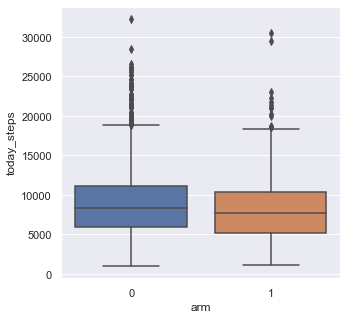

In [13]:
plt.figure(figsize=(5,5))
sns.boxplot(x="arm", y="today_steps", data=filled_dataset)  
# adaptive and uniform group seems to have roughly about the same average today_steps
print(filled_dataset.groupby(['arm']).today_steps.mean())
plt.savefig("steps.tif")

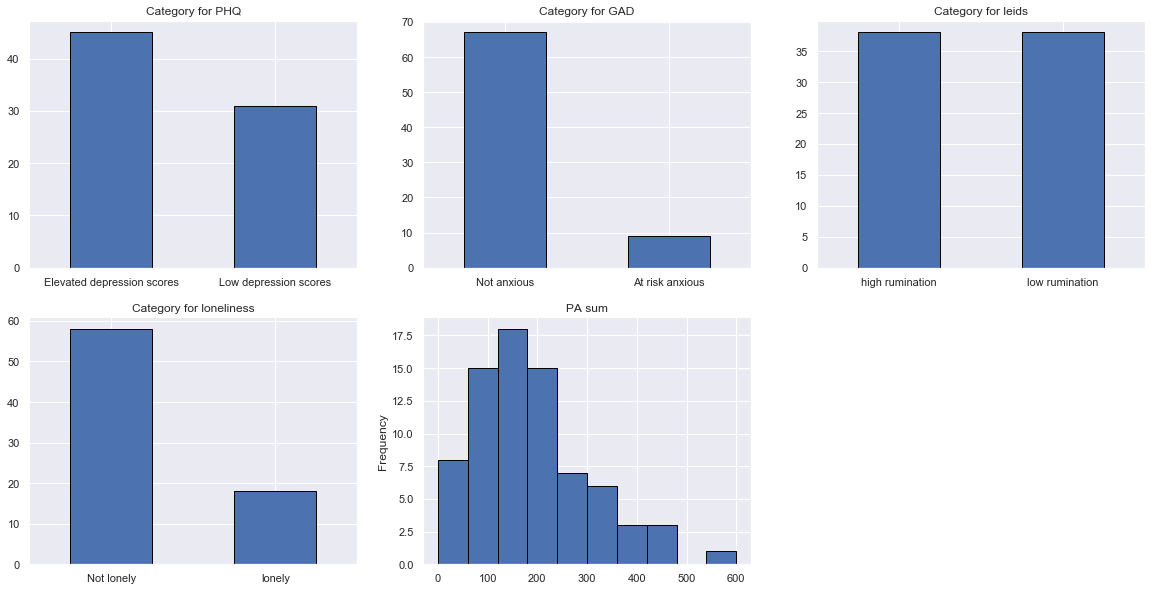

In [14]:
plt.figure(figsize=(20,10))

phq_cat = filled_dataset.groupby(["ID_DIAMANTE"]).phq_cat.describe().top.value_counts()
plt.subplot(2,3,1)
phq_cat.plot(kind="bar", rot=0, ec="black")
plt.title("Category for PHQ")

GAD_cat = filled_dataset.groupby(["ID_DIAMANTE"]).GAD_cat.describe().top.value_counts()
plt.subplot(2,3,2)
GAD_cat.plot(kind="bar", rot=0, ec="black")
plt.title("Category for GAD")

leids_cat = filled_dataset.groupby(["ID_DIAMANTE"]).leids_cat.describe().top.value_counts()
plt.subplot(2,3,3)
leids_cat.plot(kind="bar", rot=0, ec="black")
plt.title("Category for leids")

lonely_cat = filled_dataset.groupby(["ID_DIAMANTE"]).lonely_cat.describe().top.value_counts()
plt.subplot(2,3,4)
lonely_cat.plot(kind="bar", rot=0, ec="black")
plt.title("Category for loneliness")

df_PA_sum = filled_dataset.groupby(["ID_DIAMANTE"]).describe().PA_sum['max']
plt.subplot(2,3,5)
df_PA_sum.plot(kind="hist", ec="black")
plt.title("PA sum")

plt.savefig("health.tif")

### Pair feedback + motivational + timing as different combinations for F0

In [15]:
df_feedback = filled_dataset.feedback.reset_index().feedback
df_motivational = filled_dataset.motivational.reset_index().motivational
df_time_msg = filled_dataset.time_msg.reset_index().time_msg
df_today_steps = filled_dataset.today_steps.reset_index().today_steps
counts = np.zeros(13)
total_steps = np.zeros(13)
for i in range(len(filled_dataset)):
    # F0, M0
    if df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M0":
        counts[0] += 1 
        total_steps[0] += df_today_steps.loc[i]
    
    # F0, M1, T1
    elif df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T1":
        counts[1] += 1
        total_steps[1] += df_today_steps.loc[i]
        
    # F0, M1, T2
    elif df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T2":
        counts[2] += 1
        total_steps[2] += df_today_steps.loc[i]
        
    # F0, M1, T3
    elif df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T3":
        counts[3] += 1
        total_steps[3] += df_today_steps.loc[i]
        
    # F0, M1, T4
    elif df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T4":
        counts[4] += 1
        total_steps[4] += df_today_steps.loc[i]
        
    # F0, M2, T1
    elif df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T1":
        counts[5] += 1
        total_steps[5] += df_today_steps.loc[i]
        
    # F0, M2, T2
    elif df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T2":
        counts[6] += 1
        total_steps[6] += df_today_steps.loc[i]
        
    # F0, M2, T3
    elif df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T3":
        counts[7] += 1
        total_steps[7] += df_today_steps.loc[i]
        
    # F0, M2, T4
    elif df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T4":
        counts[8] += 1
        total_steps[8] += df_today_steps.loc[i]   
    
    # F0, M3, T1
    elif df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T1":
        counts[9] += 1
        total_steps[9] += df_today_steps.loc[i]
        
    # F0, M3, T2
    elif df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T2":
        counts[10] += 1
        total_steps[10] += df_today_steps.loc[i]
        
    # F0, M3, T3
    elif df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T3":
        counts[11] += 1
        total_steps[11] += df_today_steps.loc[i]     
    
    # F0, M3, T4
    elif df_feedback.loc[i] == "F0" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T4":
        counts[12] += 1
        total_steps[12] += df_today_steps.loc[i]
        
counts_F0 = counts
average_F0 = total_steps/counts

In [16]:
df_feedback = filled_dataset.feedback.reset_index().feedback
df_motivational = filled_dataset.motivational.reset_index().motivational
df_time_msg = filled_dataset.time_msg.reset_index().time_msg
df_today_steps = filled_dataset.today_steps.reset_index().today_steps
counts = np.zeros(16)
total_steps = np.zeros(16)
for i in range(len(filled_dataset)):
    # F1, M0, T1
    if df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T1":
        counts[0] += 1 
        total_steps[0] += df_today_steps.loc[i]
    
    # F1, M0, T2
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T2":
        counts[1] += 1 
        total_steps[1] += df_today_steps.loc[i]
        
    # F1, M0, T3
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T3":
        counts[2] += 1
        total_steps[2] += df_today_steps.loc[i]
        
    # F1, M0, T4
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T4":
        counts[3] += 1
        total_steps[3] += df_today_steps.loc[i]
    
    # F1, M1, T1
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T1":
        counts[4] += 1
        total_steps[4] += df_today_steps.loc[i]
        
    # F1, M1, T2
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T2":
        counts[5] += 1
        total_steps[5] += df_today_steps.loc[i]
        
    # F1, M1, T3
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T3":
        counts[6] += 1
        total_steps[6] += df_today_steps.loc[i]
        
    # F1, M2, T4
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T4":
        counts[7] += 1
        total_steps[7] += df_today_steps.loc[i]
    
    # F1, M2, T1
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T1":
        counts[8] += 1
        total_steps[8] += df_today_steps.loc[i]
        
    # F1, M2, T2
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T2":
        counts[9] += 1
        total_steps[9] += df_today_steps.loc[i]
        
    # F1, M2, T3
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T3":
        counts[10] += 1
        total_steps[10] += df_today_steps.loc[i]
        
    # F1, M2, T4
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T4":
        counts[11] += 1
        total_steps[11] += df_today_steps.loc[i]
        
    # F1, M3, T1
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T1":
        counts[12] += 1
        total_steps[12] += df_today_steps.loc[i]   
    
    # F1, M3, T2
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T2":
        counts[13] += 1
        total_steps[13] += df_today_steps.loc[i]
        
    # F1, M3, T3
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T3":
        counts[14] += 1
        total_steps[14] += df_today_steps.loc[i]
        
    # F1, M3, T4
    elif df_feedback.loc[i] == "F1" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T4":
        counts[15] += 1
        total_steps[15] += df_today_steps.loc[i]     
        
counts_F1 = counts
average_F1 = total_steps/counts

In [17]:
df_feedback = filled_dataset.feedback.reset_index().feedback
df_motivational = filled_dataset.motivational.reset_index().motivational
df_time_msg = filled_dataset.time_msg.reset_index().time_msg
df_today_steps = filled_dataset.today_steps.reset_index().today_steps
counts = np.zeros(16)
total_steps = np.zeros(16)
for i in range(len(filled_dataset)):
    # F2, M0, T1
    if df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T1":
        counts[0] += 1 
        total_steps[0] += df_today_steps.loc[i]
    
    # F2, M0, T2
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T2":
        counts[1] += 1 
        total_steps[1] += df_today_steps.loc[i]
        
    # F2, M0, T3
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T3":
        counts[2] += 1
        total_steps[2] += df_today_steps.loc[i]
        
    # F2, M0, T4
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T4":
        counts[3] += 1
        total_steps[3] += df_today_steps.loc[i]
    
    # F2, M1, T1
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T1":
        counts[4] += 1
        total_steps[4] += df_today_steps.loc[i]
        
    # F2, M1, T2
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T2":
        counts[5] += 1
        total_steps[5] += df_today_steps.loc[i]
        
    # F2, M1, T3
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T3":
        counts[6] += 1
        total_steps[6] += df_today_steps.loc[i]
        
    # F2, M2, T4
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T4":
        counts[7] += 1
        total_steps[7] += df_today_steps.loc[i]
    
    # F2, M2, T1
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T1":
        counts[8] += 1
        total_steps[8] += df_today_steps.loc[i]
        
    # F2, M2, T2
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T2":
        counts[9] += 1
        total_steps[9] += df_today_steps.loc[i]
        
    # F2, M2, T3
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T3":
        counts[10] += 1
        total_steps[10] += df_today_steps.loc[i]
        
    # F2, M2, T4
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T4":
        counts[11] += 1
        total_steps[11] += df_today_steps.loc[i]
        
    # F2, M3, T1
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T1":
        counts[12] += 1
        total_steps[12] += df_today_steps.loc[i]   
    
    # F2, M3, T2
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T2":
        counts[13] += 1
        total_steps[13] += df_today_steps.loc[i]
        
    # F2, M3, T3
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T3":
        counts[14] += 1
        total_steps[14] += df_today_steps.loc[i]
        
    # F2, M3, T4
    elif df_feedback.loc[i] == "F2" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T4":
        counts[15] += 1
        total_steps[15] += df_today_steps.loc[i]     
        
counts_F2 = counts
average_F2 = total_steps/counts

In [18]:
df_feedback = filled_dataset.feedback.reset_index().feedback
df_motivational = filled_dataset.motivational.reset_index().motivational
df_time_msg = filled_dataset.time_msg.reset_index().time_msg
df_today_steps = filled_dataset.today_steps.reset_index().today_steps
counts = np.zeros(16)
total_steps = np.zeros(16)
for i in range(len(filled_dataset)):
    # F3, M0, T1
    if df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T1":
        counts[0] += 1 
        total_steps[0] += df_today_steps.loc[i]
    
    # F3, M0, T2
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T2":
        counts[1] += 1 
        total_steps[1] += df_today_steps.loc[i]
        
    # F3, M0, T3
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T3":
        counts[2] += 1
        total_steps[2] += df_today_steps.loc[i]
        
    # F3, M0, T4
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T4":
        counts[3] += 1
        total_steps[3] += df_today_steps.loc[i]
    
    # F3, M1, T1
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T1":
        counts[4] += 1
        total_steps[4] += df_today_steps.loc[i]
        
    # F3, M1, T2
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T2":
        counts[5] += 1
        total_steps[5] += df_today_steps.loc[i]
        
    # F3, M1, T3
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T3":
        counts[6] += 1
        total_steps[6] += df_today_steps.loc[i]
        
    # F3, M2, T4
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T4":
        counts[7] += 1
        total_steps[7] += df_today_steps.loc[i]
    
    # F3, M2, T1
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T1":
        counts[8] += 1
        total_steps[8] += df_today_steps.loc[i]
        
    # F3, M2, T2
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T2":
        counts[9] += 1
        total_steps[9] += df_today_steps.loc[i]
        
    # F3, M2, T3
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T3":
        counts[10] += 1
        total_steps[10] += df_today_steps.loc[i]
        
    # F3, M2, T4
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T4":
        counts[11] += 1
        total_steps[11] += df_today_steps.loc[i]
        
    # F3, M3, T1
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T1":
        counts[12] += 1
        total_steps[12] += df_today_steps.loc[i]   
    
    # F3, M3, T2
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T2":
        counts[13] += 1
        total_steps[13] += df_today_steps.loc[i]
        
    # F3, M3, T3
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T3":
        counts[14] += 1
        total_steps[14] += df_today_steps.loc[i]
        
    # F3, M3, T4
    elif df_feedback.loc[i] == "F3" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T4":
        counts[15] += 1
        total_steps[15] += df_today_steps.loc[i]     
        
counts_F3 = counts
average_F3 = total_steps/counts

In [19]:
df_feedback = filled_dataset.feedback.reset_index().feedback
df_motivational = filled_dataset.motivational.reset_index().motivational
df_time_msg = filled_dataset.time_msg.reset_index().time_msg
df_today_steps = filled_dataset.today_steps.reset_index().today_steps
counts = np.zeros(16)
total_steps = np.zeros(16)
for i in range(len(filled_dataset)):
    # F4, M0, T1
    if df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T1":
        counts[0] += 1 
        total_steps[0] += df_today_steps.loc[i]
    
    # F4, M0, T2
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T2":
        counts[1] += 1 
        total_steps[1] += df_today_steps.loc[i]
        
    # F4, M0, T3
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T3":
        counts[2] += 1
        total_steps[2] += df_today_steps.loc[i]
        
    # F4, M0, T4
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M0" and df_time_msg.loc[i] == "T4":
        counts[3] += 1
        total_steps[3] += df_today_steps.loc[i]
    
    # F4, M1, T1
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T1":
        counts[4] += 1
        total_steps[4] += df_today_steps.loc[i]
        
    # F4, M1, T2
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T2":
        counts[5] += 1
        total_steps[5] += df_today_steps.loc[i]
        
    # F4, M1, T3
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T3":
        counts[6] += 1
        total_steps[6] += df_today_steps.loc[i]
        
    # F4, M2, T4
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M1" and df_time_msg.loc[i] == "T4":
        counts[7] += 1
        total_steps[7] += df_today_steps.loc[i]
    
    # F4, M2, T1
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T1":
        counts[8] += 1
        total_steps[8] += df_today_steps.loc[i]
        
    # F4, M2, T2
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T2":
        counts[9] += 1
        total_steps[9] += df_today_steps.loc[i]
        
    # F4, M2, T3
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T3":
        counts[10] += 1
        total_steps[10] += df_today_steps.loc[i]
        
    # F4, M2, T4
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M2" and df_time_msg.loc[i] == "T4":
        counts[11] += 1
        total_steps[11] += df_today_steps.loc[i]
        
    # F4, M3, T1
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T1":
        counts[12] += 1
        total_steps[12] += df_today_steps.loc[i]   
    
    # F4, M3, T2
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T2":
        counts[13] += 1
        total_steps[13] += df_today_steps.loc[i]
        
    # F4, M3, T3
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T3":
        counts[14] += 1
        total_steps[14] += df_today_steps.loc[i]
        
    # F4, M3, T4
    elif df_feedback.loc[i] == "F4" and df_motivational.loc[i] == "M3" and df_time_msg.loc[i] == "T4":
        counts[15] += 1
        total_steps[15] += df_today_steps.loc[i]     

counts_F4 = counts
average_F4 = total_steps/counts

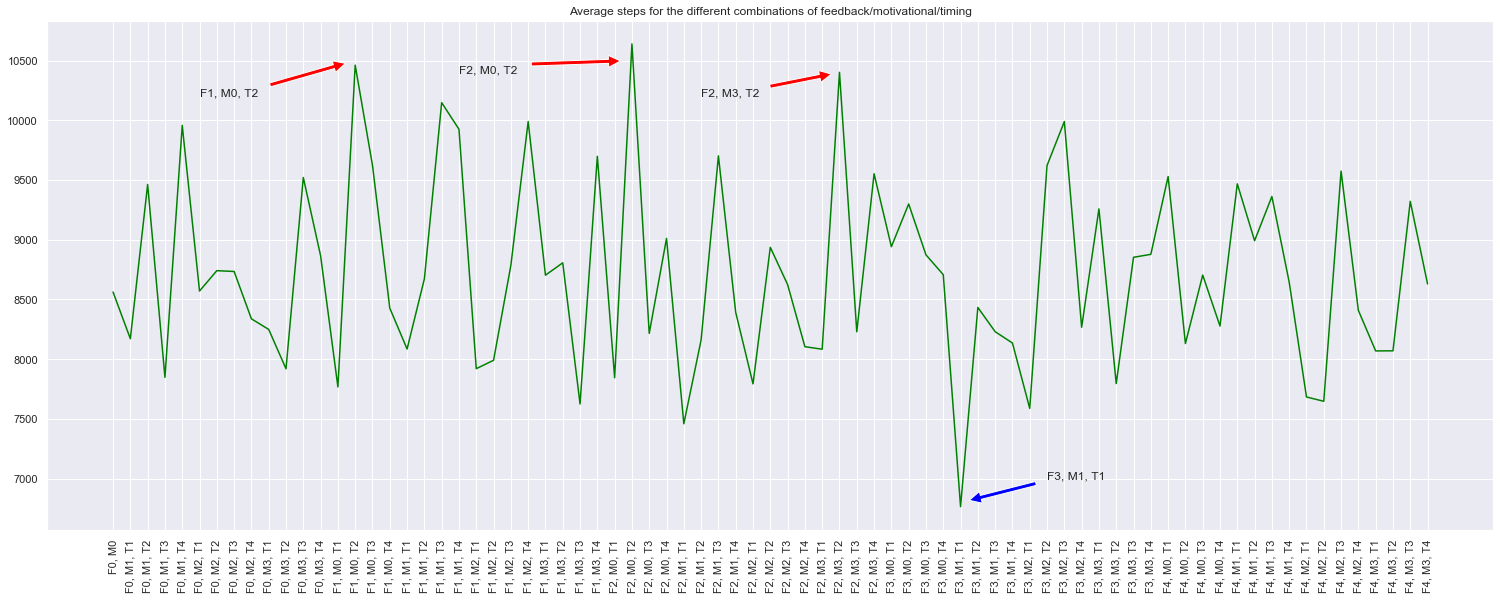

In [20]:
labels = ("F0, M0", "F0, M1, T1", "F0, M1, T2", "F0, M1, T3", "F0, M1, T4", "F0, M2, T1", "F0, M2, T2", "F0, M2, T3"
          ,"F0, M2, T4","F0, M3, T1","F0, M3, T2","F0, M3, T3","F0, M3, T4",
          
          "F1, M0, T1", "F1, M0, T2","F1, M0, T3","F1, M0, T4","F1, M1, T1","F1, M1, T2","F1, M1, T3","F1, M1, T4",
          "F1, M2, T1", "F1, M2, T2","F1, M2, T3","F1, M2, T4","F1, M3, T1","F1, M3, T2","F1, M3, T3","F1, M3, T4",
          
          "F2, M0, T1","F2, M0, T2","F2, M0, T3","F2, M0, T4", "F2, M1, T1","F2, M1, T2","F2, M1, T3","F2, M1, T4",
          "F2, M2, T1","F2, M2, T2","F2, M2, T3","F2, M2, T4","F2, M3, T1","F2, M3, T2","F2, M3, T3","F2, M3, T4",
          
          "F3, M0, T1","F3, M0, T2","F3, M0, T3","F3, M0, T4", "F3, M1, T1","F3, M1, T2","F3, M1, T3","F3, M1, T4",
          "F3, M2, T1","F3, M2, T2","F3, M2, T3","F3, M2, T4","F3, M3, T1","F3, M3, T2","F3, M3, T3","F3, M3, T4",         
          
          "F4, M0, T1","F4, M0, T2","F4, M0, T3","F4, M0, T4","F4, M1, T1","F4, M1, T2","F4, M1, T3","F4, M1, T4",
          "F4, M2, T1","F4, M2, T2","F4, M2, T3","F4, M2, T4","F4, M3, T1","F4, M3, T2","F4, M3, T3","F4, M3, T4")

average = np.concatenate((average_F0, average_F1, average_F2, average_F3, average_F4))
plt.figure(figsize = (21,8.5))
plt.plot(labels,average,color="green")
plt.xticks(rotation=90)
plt.title("Average steps for the different combinations of feedback/motivational/timing")
plt.tight_layout()

# Circling the obvious best and worst performers
# annotate(text, arrow's tip coordinates, text coordinates, arrow-size-color)
plt.annotate("F2, M0, T2", xy=("F2, M0, T2",10500), xytext=(20,10400), arrowprops=dict(facecolor="red", shrink=0.1))
plt.annotate("F1, M0, T2", xy=("F1, M0, T2",10500), xytext=(5,10200), arrowprops=dict(facecolor="red", shrink=0.1))
plt.annotate("F2, M3, T2", xy=("F2, M3, T2",10400), xytext=(34,10200), arrowprops=dict(facecolor="red", shrink=0.1))
plt.annotate("F3, M1, T1", xy=("F3, M1, T1",6800), xytext=(54,7000), arrowprops=dict(facecolor="blue", shrink=0.1))

plt.savefig("Combinations.jpg", bbox_inches='tight', dpi=150)
plt.show()

### Random Forest - on today_steps (important)

Mean Absolute Error: 2981.72 with training data from day 1 to day 4 and test data from day 5 onwards.
Mean Squared Error: 14928176.22 with training data from day 1 to day 4 and test data from day 5 onwards.
R^2 score: 0.1755 with training data from day 1 to day 4 and test data from day 5 onwards.
Mean Absolute Error: 2935.62 with training data from day 1 to day 5 and test data from day 6 onwards.
Mean Squared Error: 14472452.96 with training data from day 1 to day 5 and test data from day 6 onwards.
R^2 score: 0.2049 with training data from day 1 to day 5 and test data from day 6 onwards.
Mean Absolute Error: 2864.33 with training data from day 1 to day 6 and test data from day 7 onwards.
Mean Squared Error: 14093036.68 with training data from day 1 to day 6 and test data from day 7 onwards.
R^2 score: 0.2255 with training data from day 1 to day 6 and test data from day 7 onwards.
Mean Absolute Error: 2862.92 with training data from day 1 to day 7 and test data from day 8 onwards.
Mean

Mean Absolute Error: 3046.68 with training data from day 1 to day 31 and test data from day 32 onwards.
Mean Squared Error: 15630588.02 with training data from day 1 to day 31 and test data from day 32 onwards.
R^2 score: 0.1493 with training data from day 1 to day 31 and test data from day 32 onwards.
Mean Absolute Error: 2975.68 with training data from day 1 to day 32 and test data from day 33 onwards.
Mean Squared Error: 14969844.89 with training data from day 1 to day 32 and test data from day 33 onwards.
R^2 score: 0.1936 with training data from day 1 to day 32 and test data from day 33 onwards.
Mean Absolute Error: 2896.78 with training data from day 1 to day 33 and test data from day 34 onwards.
Mean Squared Error: 14375490.03 with training data from day 1 to day 33 and test data from day 34 onwards.
R^2 score: 0.2226 with training data from day 1 to day 33 and test data from day 34 onwards.
Mean Absolute Error: 2902.66 with training data from day 1 to day 34 and test data from 

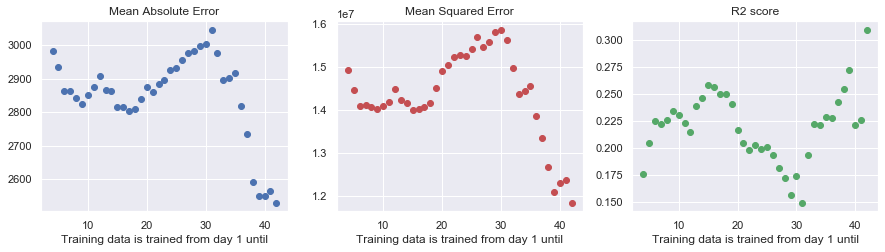

In [21]:
# Labels are the values we want to predict
labels = filled_dataset['today_steps']

# Convert categorical data into dummy variables
features = filled_dataset.drop(['today_steps',"WeekDay_dummy","ID_DIAMANTE","target_hit"], axis = 1)
features = pd.get_dummies(features)

# Create a vector to store mean absolute error (MAE)
MAE = np.zeros(39)
# Create a vector to store mean squared error (MSE)
MSE = np.zeros(39)
# Create a vector to store R^2 score (R2 score)
R2score = np.zeros(39)

# Number of trees needed for random forest is typically set as p/3 (regression) 
m = math.floor(features.shape[1]/3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3.5))

# Split into Xtrain, Xtest, Ytrain, Ytest
for i in range(4,43):
    index = 1
    train_index, test_index = features[features.Study_Day <= i].index, features[features.Study_Day > i].index
    train_index, test_index = list(train_index), list(test_index)
    Xtrain, ytrain = np.array(features.loc[train_index]), np.array(labels.loc[train_index])
    Xtest, ytest = np.array(features.loc[test_index]), np.array(labels.loc[test_index])

    # Instantiate model with m decision trees
    rf = RandomForestRegressor(n_estimators = 1000, max_features = m, random_state = 10)
    # Train the model on training data
    rf.fit(Xtrain, ytrain)
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(Xtest)

    # Calculate the absolute errors
    errors = abs(predictions - ytest)
    # Print out the mean absolute error (MAE)
    print('Mean Absolute Error:', round(np.mean(errors), 2), "with training data from day 1 to day", i
          , "and test data from day", i+1, "onwards.")
    MAE[index] = round(np.mean(errors), 2)
    ax1.plot(i, MAE[index], "bo")
    ax1.set_title("Mean Absolute Error")
    ax1.set(xlabel="Training data is trained from day 1 until")
    
    # Print out the mean squared error (MSE)
    mse = np.mean((ytest-predictions)**2)
    print('Mean Squared Error:', round(mse, 2), "with training data from day 1 to day", i
         , "and test data from day", i+1, "onwards.")
    MSE[index] = mse
    ax2.plot(i, MSE[index], "ro")
    ax2.set_title("Mean Squared Error")
    ax2.set(xlabel="Training data is trained from day 1 until")
    
    # Print R^2 score
    r2score = r2_score(ytest, predictions)
    print("R^2 score:", round(r2score, 4), "with training data from day 1 to day", i
         , "and test data from day", i+1, "onwards.")
    R2score[index] = r2score
    ax3.plot(i, R2score[index], "go")
    ax3.set_title("R2 score")
    ax3.set(xlabel="Training data is trained from day 1 until")
    
    index += 1

plt.show()

In [22]:
## We use training data from day 1 to day 39 and test data from day 40 to day 45
train_index, test_index = features[features.Study_Day <= 39].index, features[features.Study_Day > 40].index
train_index, test_index = list(train_index), list(test_index)
Xtrain, ytrain = np.array(features.loc[train_index]), np.array(labels.loc[train_index])
Xtest, ytest = np.array(features.loc[test_index]), np.array(labels.loc[test_index])

# Number of trees needed for random forest is typically set as p/3 (regression) 
m = math.floor(features.shape[1]/3)

# Instantiate model with m decision trees
rf = RandomForestRegressor(n_estimators = 1000, max_features = m, random_state = 10)
# Train the model on training data
rf.fit(Xtrain, ytrain)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# Feature_list
feature_list = list(features.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: yesterday_steps      Importance: 0.189
Variable: Study_Day            Importance: 0.103
Variable: daily_goal           Importance: 0.103
Variable: neighborhood_sum     Importance: 0.025
Variable: Week_Day_Sun         Importance: 0.024
Variable: Week_Day_Sat         Importance: 0.021
Variable: BADS_sum             Importance: 0.019
Variable: Week_Day_Fri         Importance: 0.018
Variable: PA_sum               Importance: 0.017
Variable: leids_sum            Importance: 0.016
Variable: motivational_M0      Importance: 0.014
Variable: motivational_M2      Importance: 0.014
Variable: time_msg_T3          Importance: 0.014
Variable: Week_Day_Thu         Importance: 0.013
Variable: feedback_F0          Importance: 0.013
Variable: feedback_F1          Importance: 0.013
Variable: feedback_F4          Importance: 0.013
Variable: time_msg_T1          Importance: 0.013
Variable: age                  Importance: 0.012
Variable: adults_household     Importance: 0.012
Variable: phq_sumnew

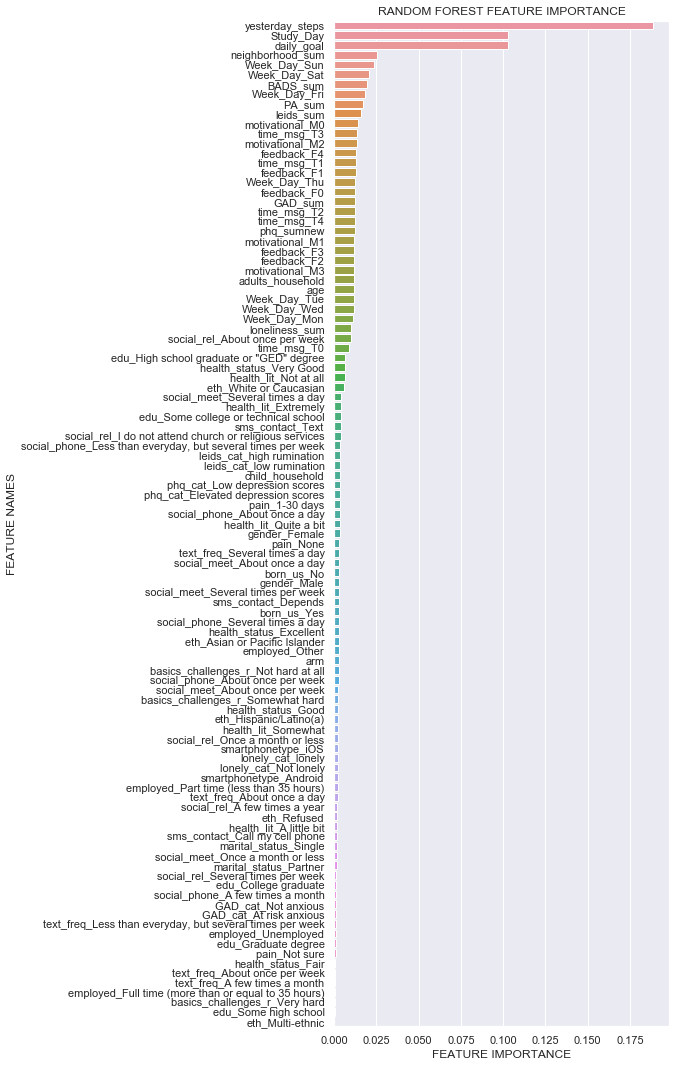

In [23]:
# Plotting out the importance of the variables
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(6,18.5))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.savefig('RF importance.jpg', bbox_inches = 'tight')

plot_feature_importance(importances, features.loc[train_index].columns, "RANDOM FOREST")

## Multi-level statistical model

In [24]:
f1 = "today_steps ~ C(Week_Day,Treatment(reference='Mon')) + C(health_lit) + C(health_status) + C(social_rel) + C(feedback) + C(motivational) + C(time_msg) + C(arm) + age + phq_sumnew + GAD_sum + leids_sum + BADS_sum + neighborhood_sum + PA_sum + yesterday_steps + daily_goal + loneliness_sum + adults_household"
mod_lme = MixedLM.from_formula(f1, groups="ID_DIAMANTE", re_formula="Study_Day", data=filled_dataset) # default re_intercept gives a random intercept for each group
mod_lme = mod_lme.fit()        
mod_lme.summary()

Maximum Likelihood optimization failed to converge. Check mle_retvals
Retrying MixedLM optimization with lbfgs
The Hessian matrix at the estimated parameter values is not positive definite.
invalid value encountered in sqrt


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Mixed Linear Model Regression Results
===================================================================================================================
Model:                                MixedLM                   Dependent Variable:                   today_steps  
No. Observations:                     3164                      Method:                               REML         
No. Groups:                           76                        Scale:                                12181946.4820
Min. group size:                      18                        Likelihood:                           -30435.9944  
Max. group size:                      45                        Converged:                            Yes          
Mean group size:                      41.6                                                                         
-------------------------------------------------------------------------------------------------------------------
                                                                 Coef.     Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------------------------------------------------
Intercept                                                         4934.637 2185.239  2.258 0.024   651.648 9217.626
C(Week_Day, Treatment(reference='Mon'))[T.Fri]                    1075.347  236.363  4.550 0.000   612.084 1538.610
C(Week_Day, Treatment(reference='Mon'))[T.Sat]                     -21.986  236.420 -0.093 0.926  -485.361  441.388
C(Week_Day, Treatment(reference='Mon'))[T.Sun]                    -963.947  236.066 -4.083 0.000 -1426.627 -501.267
C(Week_Day, Treatment(reference='Mon'))[T.Thu]                     765.593  234.741  3.261 0.001   305.509 1225.676
C(Week_Day, Treatment(reference='Mon'))[T.Tue]                     643.682  237.156  2.714 0.007   178.864 1108.500
C(Week_Day, Treatment(reference='Mon'))[T.Wed]                     458.058  238.372  1.922 0.055    -9.141  925.258
C(health_lit)[T.Extremely]                                       -1419.271  632.536 -2.244 0.025 -2659.018 -179.524
C(health_lit)[T.Not at all]                                        305.233 1051.484  0.290 0.772 -1755.639 2366.104
C(health_lit)[T.Quite a bit]                                     -1888.041  562.494 -3.357 0.001 -2990.510 -785.572
C(health_lit)[T.Somewhat]                                         -721.113  629.121 -1.146 0.252 -1954.167  511.941
C(health_status)[T.Fair]                                           928.753  942.859  0.985 0.325  -919.216 2776.722
C(health_status)[T.Good]                                           253.962  487.536  0.521 0.602  -701.591 1209.514
C(health_status)[T.Very Good]                                      576.990  415.775  1.388 0.165  -237.914 1391.894
C(social_rel)[T.About once per week]                              -169.246  712.146 -0.238 0.812 -1565.026 1226.534
C(social_rel)[T.I do not attend church or religious services]      -36.326  489.750 -0.074 0.941  -996.219  923.567
C(social_rel)[T.Once a month or less]                            -1542.508  787.913 -1.958 0.050 -3086.790    1.774
C(social_rel)[T.Several times per week]                            343.888  883.991  0.389 0.697 -1388.702 2076.479
C(feedback)[T.F1]                                                  275.234  247.737  1.111 0.267  -210.323  760.790
C(feedback)[T.F2]                                                  -26.422  246.064 -0.107 0.914  -508.698  455.854
C(feedback)[T.F3]                                                  -48.337  247.973 -0.195 0.845  -534.354  437.681
C(feedback)[T.F4]                                                 -122.901  249.462 -0.493 0.622  -611.837  366.036
C(motivational)[T.M1]                                                5.195  209.187  0.025 0.980  -404.804  415.193
C(motivational)[T.M2]                         

### K-prototype

In [27]:
# Run kprototypes with importance at least 0.006 and above

# change arm from int to object
filled_dataset = filled_dataset.astype({"arm":"object"})
filled_dataset = filled_dataset.astype({"Study_Day":"object"})

# Separating out the features
features = filled_dataset.drop(["ID_DIAMANTE","gender","eth","employed",
                              "basics_challenges_r","GAD_cat","edu","marital_status",
                               "WeekDay_dummy","text_freq","social_phone","social_meet",""
                              "sms_contact","smartphonetype","lonely_cat","pain","phq_cat",
                              "born_us","leids_cat","child_household","target_hit"], axis=1)

# Categorical features (drop out those continuous variables)
cat_features = features.drop(["age","Study_Day","phq_sumnew","GAD_sum","leids_sum","BADS_sum",
                               "neighborhood_sum","PA_sum","loneliness_sum","today_steps","yesterday_steps"
                             ,"daily_goal","adults_household"], axis=1).reset_index()
# Continuous features
cont_features = features[["age","phq_sumnew","GAD_sum","leids_sum","BADS_sum",
                               "neighborhood_sum","PA_sum","loneliness_sum","today_steps","yesterday_steps"
                             ,"daily_goal","adults_household"]]

# Standardizing the continuous features
features_stand = StandardScaler().fit_transform(cont_features)
features_stand = pd.DataFrame(features_stand, columns = ["age","phq_sumnew","GAD_sum","leids_sum","BADS_sum",
                               "neighborhood_sum","PA_sum","today_steps","yesterday_steps"
                             ,"daily_goal","loneliness_sum","adults_household"]).reset_index()

# Features that don't need to be changed
features_same = features["Study_Day"]

# Combining back the categorical and numerical variables
df = pd.concat([cat_features, features_same, features_stand], axis=1, sort=False)
# Drop the index column
#pd.set_option("display.max_rows", 5, "display.max_columns", None) 
df= df.drop(["index"],axis=1) # remove the index column
df = df.dropna() # drop the nan

In [28]:
# Split into training and test set
train_set = df[df.Study_Day <= 39]
test_set = df[df.Study_Day > 39]

# Elbow plot with cost 
costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(2, 20)):
    try:
        # Step 1: Initialize the function by specifying the number of clusters
        kproto = KPrototypes(n_clusters= i, init='Huang', verbose=2, random_state = 100)
    
        # Step 2: To build the clusters, fit.predict the data
        clusters = kproto.fit_predict(train_set, categorical=[0,1,2,3,4,5,6,7,8])
        
        # Step 3: Append the cost and number of clusters used to compute the cost to appropriate lists
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")

# Construct an elbow plot to find the optimal number for K
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
fig.show()

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 466, ncost: 30591.65548407241
Run: 1, iteration: 2/100, moves: 161, ncost: 30427.5139832193
Run: 1, iteration: 3/100, moves: 34, ncost: 30422.82770168146
Run: 1, iteration: 4/100, moves: 6, ncost: 30422.541335904472
Run: 1, iteration: 5/100, moves: 0, ncost: 30422.541335904472
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 486, ncost: 31731.52512640884
Run: 2, iteration: 2/100, moves: 290, ncost: 31273.231945478183
Run: 2, iteration: 3/100, moves: 232, ncost: 30981.73552659726
Run: 2, iteration: 4/100, moves: 142, ncost: 30865.35089489997
Run: 2, iteration: 5/100, moves: 88, ncost: 30828.287837039315
Run: 2, iteration: 6/100, moves: 81, ncost: 30786.496008696566
Run: 2, iteration: 7/100, moves: 56, ncost: 30750.648616797967
Run: 2, iteration: 8/100, moves: 36, ncost: 30734.588457318267
Run: 2, iteration: 9/100

  6%|████▌                                                                              | 1/18 [00:22<06:30, 22.95s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 540, ncost: 28885.118406390797
Run: 1, iteration: 2/100, moves: 130, ncost: 28748.833076139937
Run: 1, iteration: 3/100, moves: 128, ncost: 28569.522540264257
Run: 1, iteration: 4/100, moves: 124, ncost: 28396.726706817637
Run: 1, iteration: 5/100, moves: 123, ncost: 28253.17357502806
Run: 1, iteration: 6/100, moves: 25, ncost: 28247.169610715344
Run: 1, iteration: 7/100, moves: 27, ncost: 28236.832274092878
Run: 1, iteration: 8/100, moves: 30, ncost: 28228.165774531473
Run: 1, iteration: 9/100, moves: 32, ncost: 28219.76618336552
Run: 1, iteration: 10/100, moves: 36, ncost: 28200.9701973002
Run: 1, iteration: 11/100, moves: 35, ncost: 28185.006571556743
Run: 1, iteration: 12/100, moves: 24, ncost: 28181.39047008708
Run: 1, iteration: 13/100, moves: 1, ncost: 28181.375168971237
Run: 1, iteration: 14/100, moves: 0, ncost: 28181.375168971237
Init: initializing centroids
Init: 

Run: 10, iteration: 2/100, moves: 260, ncost: 28693.06528797911
Run: 10, iteration: 3/100, moves: 85, ncost: 28623.26999390816
Run: 10, iteration: 4/100, moves: 133, ncost: 28486.82380855265
Run: 10, iteration: 5/100, moves: 61, ncost: 28460.999440220265
Run: 10, iteration: 6/100, moves: 30, ncost: 28453.59111003837
Run: 10, iteration: 7/100, moves: 13, ncost: 28451.828071668268
Run: 10, iteration: 8/100, moves: 10, ncost: 28449.365015610536
Run: 10, iteration: 9/100, moves: 11, ncost: 28448.391511919566
Run: 10, iteration: 10/100, moves: 3, ncost: 28448.20340571936
Run: 10, iteration: 11/100, moves: 0, ncost: 28448.20340571936
Best run was number 8


 11%|█████████▏                                                                         | 2/18 [00:58<07:09, 26.84s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 888, ncost: 27313.553521448037
Run: 1, iteration: 2/100, moves: 224, ncost: 27072.19143017917
Run: 1, iteration: 3/100, moves: 106, ncost: 26889.2070338444
Run: 1, iteration: 4/100, moves: 53, ncost: 26801.03091656522
Run: 1, iteration: 5/100, moves: 55, ncost: 26743.76767705911
Run: 1, iteration: 6/100, moves: 57, ncost: 26692.89049988266
Run: 1, iteration: 7/100, moves: 59, ncost: 26658.535474820645
Run: 1, iteration: 8/100, moves: 54, ncost: 26624.189239944855
Run: 1, iteration: 9/100, moves: 66, ncost: 26590.350242465705
Run: 1, iteration: 10/100, moves: 42, ncost: 26580.415006889467
Run: 1, iteration: 11/100, moves: 20, ncost: 26577.018436564103
Run: 1, iteration: 12/100, moves: 16, ncost: 26575.101044409745
Run: 1, iteration: 13/100, moves: 9, ncost: 26574.321314902707
Run: 1, iteration: 14/100, moves: 5, ncost: 26574.043586618023
Run: 1, iteration: 15/100, moves: 3, n

Run: 10, iteration: 7/100, moves: 26, ncost: 26742.034269932225
Run: 10, iteration: 8/100, moves: 40, ncost: 26713.440423914857
Run: 10, iteration: 9/100, moves: 32, ncost: 26680.04115425322
Run: 10, iteration: 10/100, moves: 38, ncost: 26619.024895846705
Run: 10, iteration: 11/100, moves: 36, ncost: 26522.253704961393
Run: 10, iteration: 12/100, moves: 28, ncost: 26487.52946410176
Run: 10, iteration: 13/100, moves: 9, ncost: 26486.808398384437
Run: 10, iteration: 14/100, moves: 0, ncost: 26486.808398384437
Best run was number 2


 17%|█████████████▊                                                                     | 3/18 [01:37<07:35, 30.35s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 809, ncost: 27059.343886077244
Run: 1, iteration: 2/100, moves: 348, ncost: 25823.452018751028
Run: 1, iteration: 3/100, moves: 92, ncost: 25629.503106428558
Run: 1, iteration: 4/100, moves: 34, ncost: 25600.486216456295
Run: 1, iteration: 5/100, moves: 22, ncost: 25590.452318190306
Run: 1, iteration: 6/100, moves: 18, ncost: 25580.13843152034
Run: 1, iteration: 7/100, moves: 27, ncost: 25565.814482353595
Run: 1, iteration: 8/100, moves: 47, ncost: 25531.751686870455
Run: 1, iteration: 9/100, moves: 37, ncost: 25508.863375175097
Run: 1, iteration: 10/100, moves: 66, ncost: 25455.955400370196
Run: 1, iteration: 11/100, moves: 87, ncost: 25374.97396204945
Run: 1, iteration: 12/100, moves: 68, ncost: 25328.166752172445
Run: 1, iteration: 13/100, moves: 31, ncost: 25317.282741346276
Run: 1, iteration: 14/100, moves: 30, ncost: 25299.956434533207
Run: 1, iteration: 15/100, moves:

Run: 9, iteration: 12/100, moves: 3, ncost: 23721.993059289158
Run: 9, iteration: 13/100, moves: 0, ncost: 23721.993059289158
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 652, ncost: 26815.661551205056
Run: 10, iteration: 2/100, moves: 354, ncost: 26138.000686339405
Run: 10, iteration: 3/100, moves: 249, ncost: 25618.779415208424
Run: 10, iteration: 4/100, moves: 133, ncost: 25428.375074752377
Run: 10, iteration: 5/100, moves: 36, ncost: 25416.452070713673
Run: 10, iteration: 6/100, moves: 22, ncost: 25412.375086597473
Run: 10, iteration: 7/100, moves: 4, ncost: 25412.26565618298
Run: 10, iteration: 8/100, moves: 0, ncost: 25412.26565618298
Best run was number 3


 22%|██████████████████▍                                                                | 4/18 [02:17<07:47, 33.37s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 625, ncost: 24796.64089713909
Run: 1, iteration: 2/100, moves: 192, ncost: 24270.814471577287
Run: 1, iteration: 3/100, moves: 158, ncost: 22801.495862420834
Run: 1, iteration: 4/100, moves: 36, ncost: 22787.397889256234
Run: 1, iteration: 5/100, moves: 4, ncost: 22787.006712209837
Run: 1, iteration: 6/100, moves: 0, ncost: 22787.006712209837
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 854, ncost: 22868.903409847248
Run: 2, iteration: 2/100, moves: 235, ncost: 22619.096075368783
Run: 2, iteration: 3/100, moves: 94, ncost: 22562.910619626095
Run: 2, iteration: 4/100, moves: 41, ncost: 22548.400207945113
Run: 2, iteration: 5/100, moves: 6, ncost: 22547.78789646181
Run: 2, iteration: 6/100, moves: 1, ncost: 22547.693248547115
Run: 2, iteration: 7/100, mo

 28%|███████████████████████                                                            | 5/18 [03:06<08:11, 37.83s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 756, ncost: 23718.271356716697
Run: 1, iteration: 2/100, moves: 280, ncost: 23466.547146623918
Run: 1, iteration: 3/100, moves: 204, ncost: 22965.76977591742
Run: 1, iteration: 4/100, moves: 165, ncost: 21779.74284493201
Run: 1, iteration: 5/100, moves: 168, ncost: 21521.363286723754
Run: 1, iteration: 6/100, moves: 125, ncost: 21393.70189561795
Run: 1, iteration: 7/100, moves: 62, ncost: 21373.606064612344
Run: 1, iteration: 8/100, moves: 27, ncost: 21366.9379301845
Run: 1, iteration: 9/100, moves: 8, ncost: 21366.218829149067
Run: 1, iteration: 10/100, moves: 3, ncost: 21366.051356317825
Run: 1, iteration: 11/100, moves: 2, ncost: 21365.944819759912
Run: 1, iteration: 12/100, moves: 0, ncost: 21365.944819759912
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 844, ncost: 25314.037228791127
Run: 2, iteration: 2

 33%|███████████████████████████▋                                                       | 6/18 [03:47<07:46, 38.90s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 934, ncost: 21822.300198019282
Run: 1, iteration: 2/100, moves: 245, ncost: 21562.51138498762
Run: 1, iteration: 3/100, moves: 196, ncost: 21334.934617819676
Run: 1, iteration: 4/100, moves: 225, ncost: 21088.03027814479
Run: 1, iteration: 5/100, moves: 128, ncost: 21000.11515580982
Run: 1, iteration: 6/100, moves: 80, ncost: 20959.554893055276
Run: 1, iteration: 7/100, moves: 43, ncost: 20948.256959615454
Run: 1, iteration: 8/100, moves: 33, ncost: 20921.830422103703
Run: 1, iteration: 9/100, moves: 56, ncost: 20791.90906564782
Run: 1, iteration: 10/100, moves: 51, ncost: 20692.238233183565
Run: 1, iteration: 11/100, moves: 13, ncost: 20691.26388877851
Run: 1, iteration: 12/100, moves: 2, ncost: 20690.06293173265
Run: 1, iteration: 13/100, moves: 11, ncost: 20688.792030750836
Run: 1, iteration: 14/100, moves: 21, ncost: 20681.69240019963
Run: 1, iteration: 15/100, moves: 24

Run: 7, iteration: 9/100, moves: 0, ncost: 22397.220077733513
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 711, ncost: 21611.878286047224
Run: 8, iteration: 2/100, moves: 343, ncost: 20724.70299739457
Run: 8, iteration: 3/100, moves: 131, ncost: 20553.105901899427
Run: 8, iteration: 4/100, moves: 71, ncost: 20505.072208018697
Run: 8, iteration: 5/100, moves: 85, ncost: 20380.984535058215
Run: 8, iteration: 6/100, moves: 108, ncost: 20258.59133762649
Run: 8, iteration: 7/100, moves: 101, ncost: 20109.75423355133
Run: 8, iteration: 8/100, moves: 49, ncost: 20044.320007709117
Run: 8, iteration: 9/100, moves: 16, ncost: 20040.244343364677
Run: 8, iteration: 10/100, moves: 13, ncost: 20035.061566621214
Run: 8, iteration: 11/100, moves: 40, ncost: 19978.45480108751
Run: 8, iteration: 12/100, moves: 32, ncost: 19954.481176598627
Run: 8, iteration: 13/100, moves: 19, ncost: 19951.828553541294
Run: 8, iteration: 14/100, moves: 

 39%|████████████████████████████████▎                                                  | 7/18 [04:54<08:41, 47.38s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1111, ncost: 21324.099151985407
Run: 1, iteration: 2/100, moves: 492, ncost: 19982.757096047157
Run: 1, iteration: 3/100, moves: 236, ncost: 19577.762366623327
Run: 1, iteration: 4/100, moves: 69, ncost: 19536.671704335917
Run: 1, iteration: 5/100, moves: 69, ncost: 19457.00952373306
Run: 1, iteration: 6/100, moves: 53, ncost: 19407.56721015172
Run: 1, iteration: 7/100, moves: 6, ncost: 19406.810398619124
Run: 1, iteration: 8/100, moves: 0, ncost: 19406.810398619124
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1039, ncost: 22872.592471778502
Run: 2, iteration: 2/100, moves: 538, ncost: 20605.25089521403
Run: 2, iteration: 3/100, moves: 237, ncost: 19833.04465604629
Run: 2, iteration: 4/100, moves: 51, ncost: 19812.585599528957
Run: 2, iteration: 5/100, moves: 55, ncost: 19771.679490747083
Run: 2, iteration: 

Run: 10, iteration: 13/100, moves: 1, ncost: 19488.95548186842
Run: 10, iteration: 14/100, moves: 0, ncost: 19488.95548186842
Best run was number 1


 44%|████████████████████████████████████▉                                              | 8/18 [05:41<07:51, 47.13s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 947, ncost: 22128.439526305137
Run: 1, iteration: 2/100, moves: 361, ncost: 21134.861446898736
Run: 1, iteration: 3/100, moves: 201, ncost: 19409.391121579916
Run: 1, iteration: 4/100, moves: 120, ncost: 19197.846351567507
Run: 1, iteration: 5/100, moves: 75, ncost: 19091.844077988928
Run: 1, iteration: 6/100, moves: 30, ncost: 19084.139643840852
Run: 1, iteration: 7/100, moves: 15, ncost: 19080.4206092114
Run: 1, iteration: 8/100, moves: 12, ncost: 19077.1125475046
Run: 1, iteration: 9/100, moves: 6, ncost: 19072.750084851577
Run: 1, iteration: 10/100, moves: 10, ncost: 19065.744235555114
Run: 1, iteration: 11/100, moves: 0, ncost: 19065.744235555114
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 877, ncost: 21736.76763859133
Run: 2, iteration: 2/100, moves: 418, ncost: 19362.519805479136
Run: 2, iteration: 3

 50%|█████████████████████████████████████████▌                                         | 9/18 [06:24<06:53, 45.92s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 959, ncost: 19418.446879249048
Run: 1, iteration: 2/100, moves: 237, ncost: 19109.222076869555
Run: 1, iteration: 3/100, moves: 91, ncost: 19014.263995893365
Run: 1, iteration: 4/100, moves: 127, ncost: 18831.187953501118
Run: 1, iteration: 5/100, moves: 63, ncost: 18794.30875682795
Run: 1, iteration: 6/100, moves: 32, ncost: 18783.465983402923
Run: 1, iteration: 7/100, moves: 23, ncost: 18772.102284750275
Run: 1, iteration: 8/100, moves: 15, ncost: 18769.246756436623
Run: 1, iteration: 9/100, moves: 4, ncost: 18768.56062112413
Run: 1, iteration: 10/100, moves: 1, ncost: 18768.507090686122
Run: 1, iteration: 11/100, moves: 0, ncost: 18768.507090686122
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1134, ncost: 20764.9009398775
Run: 2, iteration: 2/100, moves: 426, ncost: 18696.746170088496
Run: 2, iteration: 3

Run: 9, iteration: 5/100, moves: 100, ncost: 18306.291985521675
Run: 9, iteration: 6/100, moves: 44, ncost: 18280.573062119085
Run: 9, iteration: 7/100, moves: 69, ncost: 18106.453341073055
Run: 9, iteration: 8/100, moves: 69, ncost: 18029.51326985809
Run: 9, iteration: 9/100, moves: 44, ncost: 18001.113560745347
Run: 9, iteration: 10/100, moves: 38, ncost: 17979.869030713166
Run: 9, iteration: 11/100, moves: 24, ncost: 17974.746181717164
Run: 9, iteration: 12/100, moves: 9, ncost: 17974.029197794174
Run: 9, iteration: 13/100, moves: 1, ncost: 17974.007429788646
Run: 9, iteration: 14/100, moves: 0, ncost: 17974.007429788646
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 870, ncost: 19301.085429586987
Run: 10, iteration: 2/100, moves: 293, ncost: 18854.51786357257
Run: 10, iteration: 3/100, moves: 73, ncost: 18769.613611064895
Run: 10, iteration: 4/100, moves: 68, ncost: 18663.764451902658
Run: 10, iteration: 5/100, move

 56%|█████████████████████████████████████████████▌                                    | 10/18 [07:21<06:33, 49.18s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1081, ncost: 19018.039287393327
Run: 1, iteration: 2/100, moves: 476, ncost: 17953.51590869376
Run: 1, iteration: 3/100, moves: 138, ncost: 17731.566078406133
Run: 1, iteration: 4/100, moves: 57, ncost: 17686.43430807037
Run: 1, iteration: 5/100, moves: 17, ncost: 17682.01162074116
Run: 1, iteration: 6/100, moves: 2, ncost: 17681.66629511596
Run: 1, iteration: 7/100, moves: 0, ncost: 17681.66629511596
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1086, ncost: 21206.925694899615
Run: 2, iteration: 2/100, moves: 480, ncost: 20245.69837196905
Run: 2, iteration: 3/100, moves: 266, ncost: 19564.611789448772
Run: 2, iteration: 4/100, moves: 250, ncost: 18132.925208219393
Run: 2, iteration: 5/100, moves: 81, ncost: 17504.936301555575
Run: 2, iteration: 6/100, moves: 21, ncost: 17497.450246468117
Run: 2, iteration: 7

 61%|██████████████████████████████████████████████████                                | 11/18 [08:04<05:31, 47.34s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1130, ncost: 18418.423672919747
Run: 1, iteration: 2/100, moves: 461, ncost: 17766.91138369787
Run: 1, iteration: 3/100, moves: 141, ncost: 17678.234100952883
Run: 1, iteration: 4/100, moves: 61, ncost: 17655.332537345985
Run: 1, iteration: 5/100, moves: 33, ncost: 17643.794428264224
Run: 1, iteration: 6/100, moves: 30, ncost: 17634.21465540193
Run: 1, iteration: 7/100, moves: 5, ncost: 17633.819903794974
Run: 1, iteration: 8/100, moves: 4, ncost: 17633.327751637702
Run: 1, iteration: 9/100, moves: 18, ncost: 17617.958614604588
Run: 1, iteration: 10/100, moves: 54, ncost: 17545.251261115332
Run: 1, iteration: 11/100, moves: 56, ncost: 17505.083561722648
Run: 1, iteration: 12/100, moves: 48, ncost: 17485.265026920133
Run: 1, iteration: 13/100, moves: 20, ncost: 17481.870014851036
Run: 1, iteration: 14/100, moves: 8, ncost: 17480.750111911348
Run: 1, iteration: 15/100, moves: 

Run: 9, iteration: 10/100, moves: 7, ncost: 17764.614847635752
Run: 9, iteration: 11/100, moves: 19, ncost: 17741.496568781808
Run: 9, iteration: 12/100, moves: 5, ncost: 17739.578087028673
Run: 9, iteration: 13/100, moves: 0, ncost: 17739.578087028673
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 1107, ncost: 18350.833958030813
Run: 10, iteration: 2/100, moves: 351, ncost: 17848.402036829393
Run: 10, iteration: 3/100, moves: 114, ncost: 17741.762831239346
Run: 10, iteration: 4/100, moves: 20, ncost: 17737.444978333147
Run: 10, iteration: 5/100, moves: 14, ncost: 17726.183610237906
Run: 10, iteration: 6/100, moves: 35, ncost: 17687.632395290606
Run: 10, iteration: 7/100, moves: 37, ncost: 17671.690619695593
Run: 10, iteration: 8/100, moves: 17, ncost: 17665.394869631968
Run: 10, iteration: 9/100, moves: 14, ncost: 17661.923169322585
Run: 10, iteration: 10/100, moves: 16, ncost: 17656.89497571228
Run: 10, iteration: 11/

 67%|██████████████████████████████████████████████████████▋                           | 12/18 [09:08<05:14, 52.46s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1193, ncost: 18326.808786299553
Run: 1, iteration: 2/100, moves: 459, ncost: 17588.152206689763
Run: 1, iteration: 3/100, moves: 340, ncost: 17021.717897431194
Run: 1, iteration: 4/100, moves: 127, ncost: 16902.070898940747
Run: 1, iteration: 5/100, moves: 51, ncost: 16869.873320456674
Run: 1, iteration: 6/100, moves: 23, ncost: 16863.1428224843
Run: 1, iteration: 7/100, moves: 3, ncost: 16862.969850014975
Run: 1, iteration: 8/100, moves: 5, ncost: 16862.667611139208
Run: 1, iteration: 9/100, moves: 0, ncost: 16862.667611139208
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1014, ncost: 17603.94625551127
Run: 2, iteration: 2/100, moves: 358, ncost: 16848.467230259874
Run: 2, iteration: 3/100, moves: 115, ncost: 16747.607988523294
Run: 2, iteration: 4/100, moves: 48, ncost: 16725.494798048552
Run: 2, iteration:

Run: 10, iteration: 10/100, moves: 5, ncost: 17072.56285743311
Run: 10, iteration: 11/100, moves: 1, ncost: 17072.461764577933
Run: 10, iteration: 12/100, moves: 0, ncost: 17072.461764577933
Best run was number 8


 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [10:01<04:22, 52.51s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1070, ncost: 18227.505049739106
Run: 1, iteration: 2/100, moves: 445, ncost: 17590.79541848725
Run: 1, iteration: 3/100, moves: 293, ncost: 17150.81623530602
Run: 1, iteration: 4/100, moves: 183, ncost: 16945.28504496555
Run: 1, iteration: 5/100, moves: 40, ncost: 16915.03244372018
Run: 1, iteration: 6/100, moves: 90, ncost: 16810.150178658634
Run: 1, iteration: 7/100, moves: 114, ncost: 16630.93997112566
Run: 1, iteration: 8/100, moves: 51, ncost: 16590.907310349146
Run: 1, iteration: 9/100, moves: 47, ncost: 16521.447334498396
Run: 1, iteration: 10/100, moves: 32, ncost: 16499.38167838006
Run: 1, iteration: 11/100, moves: 13, ncost: 16497.717337410115
Run: 1, iteration: 12/100, moves: 7, ncost: 16496.407704863806
Run: 1, iteration: 13/100, moves: 10, ncost: 16493.08172536613
Run: 1, iteration: 14/100, moves: 18, ncost: 16480.8441145539
Run: 1, iteration: 15/100, moves: 14,

Run: 10, iteration: 8/100, moves: 50, ncost: 16996.048888293826
Run: 10, iteration: 9/100, moves: 43, ncost: 16978.83606560011
Run: 10, iteration: 10/100, moves: 50, ncost: 16954.640367970707
Run: 10, iteration: 11/100, moves: 48, ncost: 16915.910392382535
Run: 10, iteration: 12/100, moves: 78, ncost: 16783.597133981413
Run: 10, iteration: 13/100, moves: 43, ncost: 16739.99346537051
Run: 10, iteration: 14/100, moves: 16, ncost: 16733.461832598805
Run: 10, iteration: 15/100, moves: 7, ncost: 16730.529211826586
Run: 10, iteration: 16/100, moves: 15, ncost: 16722.579470035264
Run: 10, iteration: 17/100, moves: 18, ncost: 16715.303214632848
Run: 10, iteration: 18/100, moves: 13, ncost: 16703.8300234654
Run: 10, iteration: 19/100, moves: 15, ncost: 16698.555055141358
Run: 10, iteration: 20/100, moves: 6, ncost: 16697.257269713293
Run: 10, iteration: 21/100, moves: 1, ncost: 16697.120894743966
Run: 10, iteration: 22/100, moves: 0, ncost: 16697.120894743966
Best run was number 1


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [11:03<03:42, 55.56s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 892, ncost: 17474.896086176013
Run: 1, iteration: 2/100, moves: 379, ncost: 16797.559601880464
Run: 1, iteration: 3/100, moves: 119, ncost: 16713.507122989573
Run: 1, iteration: 4/100, moves: 56, ncost: 16676.769807751472
Run: 1, iteration: 5/100, moves: 29, ncost: 16657.46707711984
Run: 1, iteration: 6/100, moves: 36, ncost: 16607.4916203912
Run: 1, iteration: 7/100, moves: 57, ncost: 16524.443623867308
Run: 1, iteration: 8/100, moves: 76, ncost: 16411.598298389534
Run: 1, iteration: 9/100, moves: 55, ncost: 16367.90768795624
Run: 1, iteration: 10/100, moves: 17, ncost: 16363.010493004682
Run: 1, iteration: 11/100, moves: 8, ncost: 16361.112324690515
Run: 1, iteration: 12/100, moves: 12, ncost: 16352.31641

 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [11:54<02:42, 54.10s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1136, ncost: 17389.325201419633
Run: 1, iteration: 2/100, moves: 450, ncost: 16493.294645465023
Run: 1, iteration: 3/100, moves: 195, ncost: 16185.243048979737
Run: 1, iteration: 4/100, moves: 95, ncost: 16015.928623139464
Run: 1, iteration: 5/100, moves: 49, ncost: 15947.461535464025
Run: 1, iteration: 6/100, moves: 23, ncost: 15938.404230977038
Run: 1, iteration: 7/100, moves: 50, ncost: 15877.091058107362
Run: 1, iteration: 8/100, moves: 52, ncost: 15788.897156656403
Run: 1, iteration: 9/100, moves: 5, ncost: 15787.768515596797
Run: 1, iteration: 10/100, moves: 0, ncost: 15787.768515596797
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1192, ncost: 17369.680484717905
Run: 2, iteration: 2/100, moves: 378, ncost: 16854.626063832962
Run: 2, iteration: 3/100, moves: 237, ncost: 16531.58503512836
Run: 2, iterati

Run: 10, iteration: 6/100, moves: 15, ncost: 15940.180915703097
Run: 10, iteration: 7/100, moves: 19, ncost: 15931.449464266847
Run: 10, iteration: 8/100, moves: 2, ncost: 15931.268713351596
Run: 10, iteration: 9/100, moves: 1, ncost: 15931.228852219749
Run: 10, iteration: 10/100, moves: 0, ncost: 15931.228852219749
Best run was number 1


 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [12:53<01:51, 55.65s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 949, ncost: 16848.137010188264
Run: 1, iteration: 2/100, moves: 363, ncost: 16115.608439538242
Run: 1, iteration: 3/100, moves: 144, ncost: 15989.891019160235
Run: 1, iteration: 4/100, moves: 35, ncost: 15977.9578072779
Run: 1, iteration: 5/100, moves: 17, ncost: 15963.225991376215
Run: 1, iteration: 6/100, moves: 49, ncost: 15887.472643781222
Run: 1, iteration: 7/100, moves: 52, ncost: 15815.295209085696
Run: 1, iteration: 8/100, moves: 25, ncost: 15804.323469323086
Run: 1, iteration: 9/100, moves: 11, ncost: 15803.26399538929
Run: 1, ite

Run: 9, iteration: 8/100, moves: 2, ncost: 16457.16977106789
Run: 9, iteration: 9/100, moves: 0, ncost: 16457.16977106789
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 1021, ncost: 17584.80487013898
Run: 10, iteration: 2/100, moves: 421, ncost: 16567.124550268047
Run: 10, iteration: 3/100, moves: 222, ncost: 16012.192336015434
Run: 10, iteration: 4/100, moves: 88, ncost: 15825.981725410897
Run: 10, iteration: 5/100, moves: 51, ncost: 15776.663212085934
Run: 10, iteration: 6/100, moves: 17, ncost: 15772.21692436315
Run: 10, iteration: 7/100, moves: 3, ncost: 15771.906919251805
Run: 10, iteration: 8/100, moves: 0, ncost: 15771.906919251805
Best run was number 3


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [13:59<00:58, 58.56s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1021, ncost: 16000.942917065438
Run: 1, iteration: 2/100, moves: 320, ncost: 15654.102732579278
Run: 1, iteration: 3/100, moves: 198, ncost: 15354.691522742056
Run: 1, iteration: 4/100, moves: 102, ncost: 15270.959528277459
Run: 1, iteration: 5/100, moves: 32, ncost: 15261.898191599686
Run: 1, iteration: 6/100, moves: 3, ncost: 15260.88896995285
Run: 1, iteration: 7/100, moves: 2, ncost: 15260.279099193223
Run: 1, iteration: 8/100, moves: 0, ncost: 15260.279099193223
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1015, ncost: 1613

Run: 10, iteration: 1/100, moves: 918, ncost: 16721.493190371173
Run: 10, iteration: 2/100, moves: 387, ncost: 16082.31728179289
Run: 10, iteration: 3/100, moves: 191, ncost: 15891.220823391708
Run: 10, iteration: 4/100, moves: 67, ncost: 15853.069856264414
Run: 10, iteration: 5/100, moves: 31, ncost: 15840.466437629535
Run: 10, iteration: 6/100, moves: 67, ncost: 15715.400784139089
Run: 10, iteration: 7/100, moves: 95, ncost: 15569.54147215312
Run: 10, iteration: 8/100, moves: 33, ncost: 15550.919934309108
Run: 10, iteration: 9/100, moves: 32, ncost: 15525.476975112615
Run: 10, iteration: 10/100, moves: 25, ncost: 15510.78887065174
Run: 10, iteration: 11/100, moves: 16, ncost: 15499.635829646715
Run: 10, iteration: 12/100, moves: 14, ncost: 15492.902820200494
Run: 10, iteration: 13/100, moves: 0, ncost: 15492.902820200494
Best run was number 5


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [15:05<00:00, 50.32s/it]


In [29]:
# categorical columns
categorical_columns = [0,1,2,3,4,5,6,7,8]

kproto = KPrototypes(n_clusters= 8, init='Huang', verbose=2, random_state = 100)
clusters = kproto.fit_predict(test_set, categorical=categorical_columns)

# Predicted Clusters
clusters = kproto.fit_predict(test_set, categorical=categorical_columns)
pd.set_option("display.max_rows", None, "display.max_columns", None) 

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 103, ncost: 2566.768329112735
Run: 1, iteration: 2/100, moves: 34, ncost: 2455.7346681429813
Run: 1, iteration: 3/100, moves: 3, ncost: 2454.6581945167577
Run: 1, iteration: 4/100, moves: 8, ncost: 2438.2511084637686
Run: 1, iteration: 5/100, moves: 13, ncost: 2402.242430737272
Run: 1, iteration: 6/100, moves: 6, ncost: 2393.8434221420735
Run: 1, iteration: 7/100, moves: 13, ncost: 2364.858983707418
Run: 1, iteration: 8/100, moves: 6, ncost: 2357.0986482901576
Run: 1, iteration: 9/100, moves: 1, ncost: 2356.7961833562085
Run: 1, iteration: 10/100, moves: 0, ncost: 2356.7961833562085
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 91, ncost: 2489.3732854869163
Run: 2, iteration: 2/100, moves: 12, ncost: 2475.843407797351
Run: 2, iteration: 3/100, moves: 2,

Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 106, ncost: 2734.0358816759035
Run: 6, iteration: 2/100, moves: 49, ncost: 2571.2602272307577
Run: 6, iteration: 3/100, moves: 30, ncost: 2490.5513989975448
Run: 6, iteration: 4/100, moves: 8, ncost: 2482.050396479471
Run: 6, iteration: 5/100, moves: 5, ncost: 2477.957465521324
Run: 6, iteration: 6/100, moves: 3, ncost: 2473.0555988166675
Run: 6, iteration: 7/100, moves: 0, ncost: 2473.0555988166675
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 88, ncost: 2460.0542556410383
Run: 7, iteration: 2/100, moves: 22, ncost: 2439.462216381129
Run: 7, iteration: 3/100, moves: 10, ncost: 2424.7304917446963
Run: 7, iteration: 4/100, moves: 14, ncost: 2406.1891094489188
Run: 7, iteration: 5/100, moves: 5, ncost: 2400.659157559941
Run: 7, iteration: 6/100, moves: 1, ncost: 2400.4931877774693
Run: 7, iteration: 7/100, moves: 0, ncost: 2400.49318777746

In [30]:
# Setting the objects to category
cat_data = test_set.copy()
for i in cat_data.select_dtypes("object"):
    cat_data[i] = cat_data[i].astype("category")

# kprototypes labels
proto_labs = kproto.labels_  

In [31]:
clf_kp = LGBMClassifier(colsample_by_tree = 0.8)
cv_scores_kp = cross_val_score(clf_kp, cat_data, proto_labs, scoring = "f1_weighted")
print(f'CV F1 score for k-prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for k-prototypes clusters is 0.7031037708498985


In [32]:
clf_kp.fit(cat_data, proto_labs)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LGBMClassifier(colsample_by_tree=0.8)

In [33]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(cat_data)

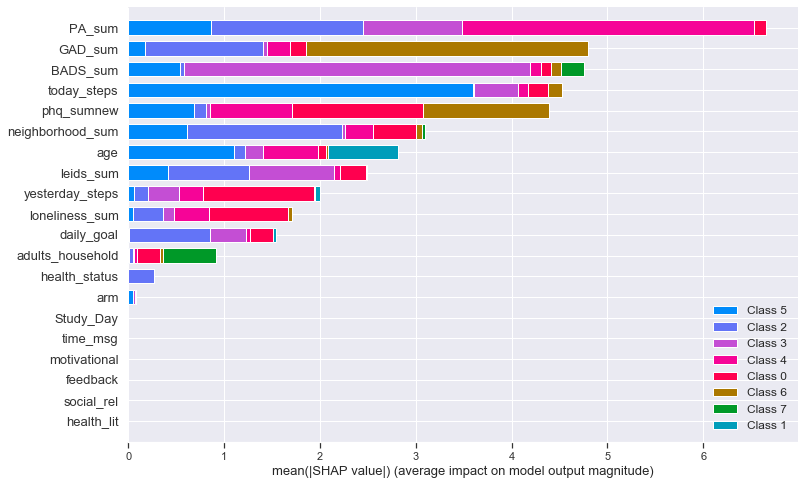

In [34]:
### SHAP summary plot ###
shap.summary_plot(shap_values_kp, cat_data, plot_type='bar', plot_size=(12,8))

In [35]:
# This gives the cluster grouping for each individual rows
cluster_dict = []
for c in clusters:
    cluster_dict.append(c)

In [36]:
# Assign back a clusters column in the dataframe to see which rows belong to which clusters
test_set["cluster_id"] = cluster_dict

C:\Users\Kiat Kai\Documents\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
###############################################################################################
##### Here we converting back the scaled variables in the clusters to its original number #####
###############################################################################################

# Continuous variables
cont_variables = ["age","phq_sumnew","GAD_sum","leids_sum","BADS_sum","neighborhood_sum","PA_sum",
                 "today_steps","yesterday_steps","daily_goal","loneliness_sum","adults_household"] 
List = []
for i in kproto.cluster_centroids_[0]:
    lst = []
    for j in range(12):         # Times standard deviation plus mean
        lst.append(round(i[j] * filled_dataset[cont_variables[j]].std() + filled_dataset[cont_variables[j]].mean(),3))
    List.append(lst)

cont_variables_df = pd.DataFrame(List, columns = cont_variables)

# Categorical variables
cat_variables = ["Week_Day","health_lit","health_status","social_rel","feedback","motivational",
                 "time_msg","arm","Study_Day"]
Cat = []
for i in kproto.cluster_centroids_[1]:
    lst = []
    for j in range(9): # 9 is the number of variables
        lst.append(i[j])
    Cat.append(lst)

cat_variables_df = pd.DataFrame(Cat, columns = cat_variables)

clusters = cont_variables_df.join(cat_variables_df)
print(clusters)

clusters.to_csv("clusters_today_final.csv")

      age  phq_sumnew  GAD_sum  leids_sum  BADS_sum  neighborhood_sum  \
0  21.565       1.086    0.652      9.608    28.913            13.696   
1  33.002       8.000    7.000     11.000    32.000            19.001   
2  19.804       6.261    3.935     17.066    31.196            19.131   
3  19.946       4.911    2.107      9.482    22.213            13.946   
4  18.975       2.274    0.449     11.825    30.950            11.875   
5  21.017       4.066    2.883     11.700    33.334            16.367   
6  19.477       9.682   12.888     16.410    32.478            12.704   
7  21.000       3.000   -0.001     14.000    38.001             8.999   

    PA_sum  today_steps  yesterday_steps  daily_goal  loneliness_sum  \
0  209.354     4003.261        13092.429   11047.802           6.598   
1  119.992     5214.660         4095.663    7085.411           4.285   
2  245.990     6476.534         9685.930   10176.912           6.686   
3  101.239     6956.046         7546.215    8830.301  

### K-Mediods

In [41]:
# change arm from int to object
filled_dataset = filled_dataset.astype({"arm":"object"})
filled_dataset = filled_dataset.astype({"Study_Day":"object"})

# Separating out the features
features = filled_dataset.drop(["ID_DIAMANTE","gender","eth","employed",
                              "basics_challenges_r","GAD_cat","edu","marital_status",
                               "WeekDay_dummy","text_freq","social_phone","social_meet",""
                              "sms_contact","smartphonetype","lonely_cat","pain","phq_cat",
                              "born_us","leids_cat","child_household","target_hit"], axis=1)

# Categorical features (drop out those continuous variables)
cat_features = features.drop(["age","Study_Day","phq_sumnew","GAD_sum","leids_sum","BADS_sum",
                               "neighborhood_sum","PA_sum","loneliness_sum","today_steps","yesterday_steps"
                             ,"daily_goal","adults_household"], axis=1).reset_index()
# Continuous features
cont_features = features[["age","phq_sumnew","GAD_sum","leids_sum","BADS_sum",
                               "neighborhood_sum","PA_sum","loneliness_sum","today_steps","yesterday_steps"
                             ,"daily_goal","adults_household"]]

# Standardizing the continuous features
features_stand = StandardScaler().fit_transform(cont_features)
features_stand = pd.DataFrame(features_stand, columns = ["age","phq_sumnew","GAD_sum","leids_sum","BADS_sum",
                               "neighborhood_sum","PA_sum","today_steps","yesterday_steps"
                             ,"daily_goal","loneliness_sum","adults_household"]).reset_index()

# Features that don't need to be changed
features_same = features["Study_Day"]

# Combining back the categorical and numerical variables
df = pd.concat([cat_features, features_same, features_stand], axis=1, sort=False)
# Drop the index column
#pd.set_option("display.max_rows", 5, "display.max_columns", None) 
df= df.drop(["index"],axis=1) # remove the index column
df = df.dropna() # drop the nan

# Combining back the categorical and numerical variables
df_weekly_kmeans = pd.concat([cat_features, features_same, features_stand], axis=1, sort=False)

df_weekly_kmeans = df_weekly_kmeans.drop(["index"],axis=1) # remove the index column
df_weekly_kmeans = df_weekly_kmeans.dropna() # drop the nan

# Split into train and test set before converting "week_number" into ordinal variable
train_set_beforedummy = df_weekly_kmeans[df_weekly_kmeans["Study_Day"] <= 39]
test_set_beforedummy = df_weekly_kmeans[df_weekly_kmeans["Study_Day"] > 39]

# Get dummies (ENCODING into dummy variables)
train_set_afterdummy = pd.get_dummies(train_set_beforedummy)
test_set_afterdummy = pd.get_dummies(test_set_beforedummy)

In [45]:
##################################################################  
#### First we need to convert dataset to the one-hot encoding ####  
##################################################################

# Setting the objects to category
test_data = test_set_beforedummy.copy()
for j in test_data.select_dtypes("object"):
    test_data[j] = test_data[j].astype("category")

model_outputs = pd.DataFrame(columns = ['Number of clusters', 'F1 score'])

#Elbow method to choose the optimal number of clusters
SSE = {}

for i in tqdm(range(2, 18)):
    try:
        kmediods = KMedoids(n_clusters= i, random_state = 100).fit(train_set_afterdummy)

        # Predicted Clusters using test set
        kmediods_test = KMedoids(n_clusters= i, random_state = 100).fit(test_set_afterdummy)

        # kmeans labels for test set
        kmediods_labels = kmediods_test.labels_  
        
        # F1_score 
        clf_kmediods = LGBMClassifier(colsample_by_tree = 0.8)
        cv_scores_kmediods_test = cross_val_score(clf_kmediods, test_data, kmediods_labels, scoring = "f1_weighted")
        print(f'CV F1 score for {i}-prototypes clusters is {np.mean(cv_scores_kmediods_test)}')
    

        # Create a dataframe to store the F1_scores for all the different clusters
        model_outputs = model_outputs.append(pd.DataFrame({'Number of clusters': i, 
                                                           'F1 score': np.mean(cv_scores_kmediods_test)},
                                                               index = [0]),
                                                                 ignore_index = True)
    except:
        print(f"Can't cluster with {i} clusters")

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 2-prototypes clusters is 0.7712220170451113


  6%|█████▏                                                                             | 1/16 [00:00<00:11,  1.29it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 3-prototypes clusters is 0.6227862261292465


 12%|██████████▍                                                                        | 2/16 [00:01<00:12,  1.13it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 4-prototypes clusters is 0.5663469693770447


 19%|███████████████▌                                                                   | 3/16 [00:03<00:13,  1.02s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 5-prototypes clusters is 0.5361541365032576


 25%|████████████████████▊                                                              | 4/16 [00:04<00:14,  1.18s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 6-prototypes clusters is 0.487421623861481


 31%|█████████████████████████▉                                                         | 5/16 [00:06<00:14,  1.33s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 7-prototypes clusters is 0.46519070585331057


 38%|███████████████████████████████▏                                                   | 6/16 [00:08<00:14,  1.49s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 8-prototypes clusters is 0.3730993193075474


 44%|████████████████████████████████████▎                                              | 7/16 [00:10<00:14,  1.62s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 9-prototypes clusters is 0.3283898169494337


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:12<00:14,  1.83s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 10-prototypes clusters is 0.21320313080633083


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:15<00:14,  2.06s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 11-prototypes clusters is 0.2261635031266831


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:18<00:14,  2.36s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 12-prototypes clusters is 0.2331593601330443


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:21<00:12,  2.54s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 13-prototypes clusters is 0.19577938936380998


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:24<00:10,  2.69s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 14-prototypes clusters is 0.2870317895898391


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:27<00:08,  2.85s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 15-prototypes clusters is 0.23690326277732293


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:30<00:05,  2.97s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 16-prototypes clusters is 0.2614613878512596


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:34<00:03,  3.09s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 17-prototypes clusters is 0.20856514099935156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:37<00:00,  2.36s/it]


In [40]:
model_outputs = pd.DataFrame(columns = ['Number of clusters', 'F1 score'])

#Elbow method to choose the optimal number of clusters
SSE = {}

for i in tqdm(range(2, 18)):
    try:
        kmeans = KMeans(n_clusters= i, random_state = 100).fit(train_set_afterdummy)

        # Predicted Clusters using test set
        kmeans_test = KMeans(n_clusters= i, random_state = 100).fit(test_set_afterdummy)

        # kmeans labels for test set
        kmeans_labels = kmeans_test.labels_ 
        
        # F1_score 
        clf_kmeans = LGBMClassifier(colsample_by_tree = 0.8)
        cv_scores_kmeans_test = cross_val_score(clf_kmeans, test_set_afterdummy, kmeans_labels, scoring = "f1_weighted")
        print(f'CV F1 score for {i}-prototypes clusters is {np.mean(cv_scores_kmeans_test)}')
    

        # Create a dataframe to store the F1_scores for all the different clusters
        model_outputs = model_outputs.append(pd.DataFrame({'Number of clusters': i, 
                                                           'F1 score': np.mean(cv_scores_kmeans_test)},
                                                               index = [0]),
                                                                 ignore_index = True)
    except:
        print(f"Can't cluster with {i} clusters")

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 2-prototypes clusters is 0.9358355260359265
Can't cluster with 2 clusters


  6%|█████▏                                                                             | 1/16 [00:00<00:08,  1.75it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 3-prototypes clusters is 0.8475220102934419
Can't cluster with 3 clusters


 12%|██████████▍                                                                        | 2/16 [00:01<00:10,  1.32it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 4-prototypes clusters is 0.8808846720197284
Can't cluster with 4 clusters


 19%|███████████████▌                                                                   | 3/16 [00:02<00:11,  1.12it/s]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 5-prototypes clusters is 0.7989345058366062
Can't cluster with 5 clusters


 25%|████████████████████▊                                                              | 4/16 [00:04<00:12,  1.04s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 6-prototypes clusters is 0.8836071491769653
Can't cluster with 6 clusters


 31%|█████████████████████████▉                                                         | 5/16 [00:05<00:13,  1.19s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 7-prototypes clusters is 0.7472142396033374
Can't cluster with 7 clusters


 38%|███████████████████████████████▏                                                   | 6/16 [00:07<00:13,  1.31s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 8-prototypes clusters is 0.8255733557787407
Can't cluster with 8 clusters


 44%|████████████████████████████████████▎                                              | 7/16 [00:09<00:13,  1.45s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 9-prototypes clusters is 0.8180267282952285
Can't cluster with 9 clusters


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:11<00:13,  1.68s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 10-prototypes clusters is 0.806488762273813
Can't cluster with 10 clusters


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:13<00:12,  1.79s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 11-prototypes clusters is 0.8297358833731014
Can't cluster with 11 clusters


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:15<00:11,  1.96s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 12-prototypes clusters is 0.771297713197231
Can't cluster with 12 clusters


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:18<00:11,  2.21s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 13-prototypes clusters is 0.8352418335709014
Can't cluster with 13 clusters


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:21<00:09,  2.42s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 14-prototypes clusters is 0.7603556397306397
Can't cluster with 14 clusters


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:24<00:07,  2.47s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 15-prototypes clusters is 0.8586627870180502
Can't cluster with 15 clusters


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:27<00:05,  2.70s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 16-prototypes clusters is 0.8412656099122264
Can't cluster with 16 clusters


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:31<00:02,  2.97s/it]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for 17-prototypes clusters is 0.9312742941408356
Can't cluster with 17 clusters


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.14s/it]
